In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from data import *




class MFModel(object):

    def __init__(self, rates_dict, test_rates_dict, num_users, num_items, hidden_dim, lr, gamma, epochs):
        """ Params:
        1) ratings - rating matrix (as dict)
        2) hidden_dim  - number of latent dimensions (as integer)
        3) lr - learning rate (as float)
        4) gamma - regulaizer (as float)
        5) opechs - as int
        """

        self.ratings_dict = rates_dict
        self.test_ratings_dict = test_rates_dict
        self.num_users = num_users
        self.num_items = num_items
        self.K = hidden_dim
        self.lr = lr
        self.gamma = gamma
        self.epochs = epochs
        self.scbd = []

    def init(self, isize, ik, kind='normal'):
        if kind == 'normal':
            return np.random.normal(scale=1.0/ik, size=(isize, ik))
        elif kind == 'uniform':
            return np.random.uniform(-1.0/ik, 1.0/ik)


    def train_model(self):

        def reset(samples):
            np.random.shuffle(samples)

        self.samples = []
        # prepare the samples samples
        for u, items in self.ratings_dict.items():
            for i, r, _ in items:
                self.samples += [(u, i, r)]

        self.U = self.init(self.num_users, self.K, kind='normal')
        self.V = self.init(self.num_items, self.K, kind='normal')

        # Initialize the biases
        self.bu = np.zeros(self.num_users)
        self.bv = np.zeros(self.num_items)


        for epoch in range(self.epochs):
            reset(self.samples)
            self.LearnModelFromDataUsingSGD()
            train_rmse = self.RMSE(is_train=True)
            val_rmse = self.RMSE()
            print("[Epoch %d] : train RMSE = %.4f" % (epoch, train_rmse))
            if epoch % 5 == 0:
                print("[Epoch %d] : validation RMSE = %.4f" % (epoch, val_rmse))
            self.scbd.append((epoch, train_rmse, val_rmse))


    def LearnModelFromDataUsingSGD (self):
        for u, v, rate in self.samples:
            prediction = self.bu[u] + self.bv[v] + self.U[u, :].dot(self.V[v, :].T)
            err = (rate - prediction)

            # update biases
            self.bu[u] += self.lr * (err - self.gamma * self.bu[u])
            self.bv[v] += self.lr * (err - self.gamma * self.bv[v])

            # update user item metrices
            self.U[u, :] += self.lr * (err * self.V[v, :] - self.gamma * self.U[u, :])
            self.V[v, :] += self.lr * (err * self.U[u, :] - self.gamma * self.V[v, :])



    def RMSE(self, is_train=False):
        mod_pred = self.bu[:,np.newaxis] + self.bv[np.newaxis:,] + self.U.dot(self.V.T)
        total_err = 0
        r_cnt = 0
        ratings_dict = self.ratings_dict if is_train else self.test_ratings_dict
        for u, items in ratings_dict.items():
            for i, r, _ in items:
                total_err += pow(r - mod_pred[u, i], 2)
                r_cnt += 1
        return np.sqrt(total_err / r_cnt)



# TODO: Igal to implement evaluation class (take RMSE from above)
# class EvalModel(MFModel):
#     def __init__(self, ratings_dict, model):
#         """ Params:
#        ratings_dict - rating matrix (as dict)
#        """
#
#     def EvalModel(self, input, kind='rmse'):
#         if kind == 'rmse':
#             return self.RMSE(input)





if __name__ == '__main__':
    X_train, X_test, users, items = create_user_item_map('../ml-1m/ratings.dat', '', percent=0.8, sort_ratings=True)
    model = MFModel(X_train, X_test, users, items, hidden_dim=40, lr=0.001, gamma=0.1, epochs=100)
    print("Starting training ...")
    model.train_model()
    # predict
#     model.ratings_dict = X_test
#     test_rmse = model.RMSE()
#     print("Test RMSE: %.4f" % (test_rmse))


Starting training ...
[Epoch 0] : train RMSE = 1.9689
[Epoch 0] : validation RMSE = 2.0426
[Epoch 1] : train RMSE = 1.5183
[Epoch 2] : train RMSE = 1.3390
[Epoch 3] : train RMSE = 1.2427
[Epoch 4] : train RMSE = 1.1818
[Epoch 5] : train RMSE = 1.1393
[Epoch 5] : validation RMSE = 1.2002
[Epoch 6] : train RMSE = 1.1078
[Epoch 7] : train RMSE = 1.0834
[Epoch 8] : train RMSE = 1.0640
[Epoch 9] : train RMSE = 1.0481
[Epoch 10] : train RMSE = 1.0350
[Epoch 10] : validation RMSE = 1.0813
[Epoch 11] : train RMSE = 1.0238
[Epoch 12] : train RMSE = 1.0142
[Epoch 13] : train RMSE = 1.0059
[Epoch 14] : train RMSE = 0.9988
[Epoch 15] : train RMSE = 0.9925
[Epoch 15] : validation RMSE = 1.0304
[Epoch 16] : train RMSE = 0.9869
[Epoch 17] : train RMSE = 0.9819
[Epoch 18] : train RMSE = 0.9776
[Epoch 19] : train RMSE = 0.9735
[Epoch 20] : train RMSE = 0.9699
[Epoch 20] : validation RMSE = 1.0023
[Epoch 21] : train RMSE = 0.9666
[Epoch 22] : train RMSE = 0.9635
[Epoch 23] : train RMSE = 0.9608
[Epoch 2

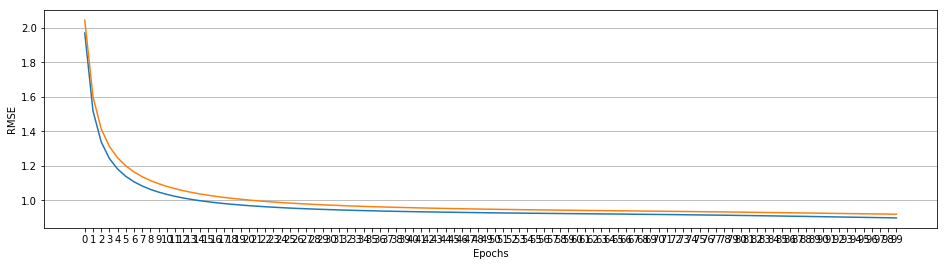

In [10]:
train_rmse = [t for e, t, v in model.scbd]
test_rmse = [v for e, t, v in model.scbd]
epochs = [e for e, t, v in model.scbd]
plt.figure(figsize=((16,4)))
plt.plot(epochs, train_rmse)
plt.plot(epochs, test_rmse)
plt.xticks(epochs)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")